In [18]:
import numpy as np

In [19]:
import pandas as pd

In [20]:
import matplotlib.pyplot as plt

In [21]:
df = pd.read_excel("data.xls")

In [22]:
rndGenerator = np.random.default_rng()

def genInitiationTime(e):
    return rndGenerator.exponential(e, 10000)

def genCallDuration(e):
    return rndGenerator.exponential(e, 10000)

def genCarVelocity(e, s):
    return rndGenerator.normal(e, s, 10000)

def genCarPosition():
    return rndGenerator.integers(0, 200001, 10000)

def genBaseStation():
    return rndGenerator.integers(1, 21, 10000)

def genCarDirection():
    return rndGenerator.integers(0, 2, 10000)

In [23]:
arrival_timings = df["Arrival time (sec)"].values

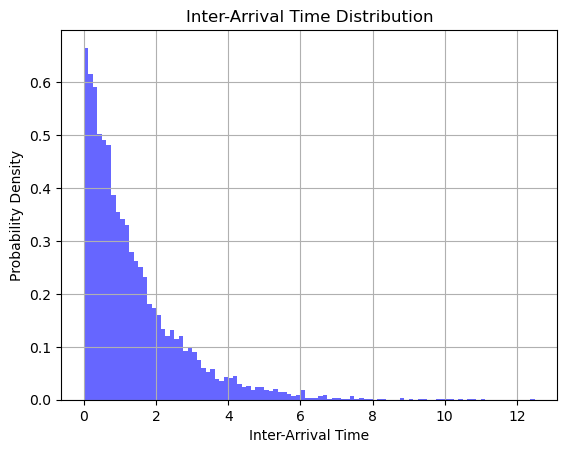

In [24]:
# Calculate inter-arrival times
inter_arrival_times = np.diff(arrival_timings)

# Plot histogram of inter-arrival times
plt.hist(inter_arrival_times, bins=100, density=True, alpha=0.6, color='b')
plt.xlabel('Inter-Arrival Time')
plt.ylabel('Probability Density')
plt.title('Inter-Arrival Time Distribution')
plt.grid(True)
plt.show()

In [25]:
print(inter_arrival_times.mean())

1.3698169264765245


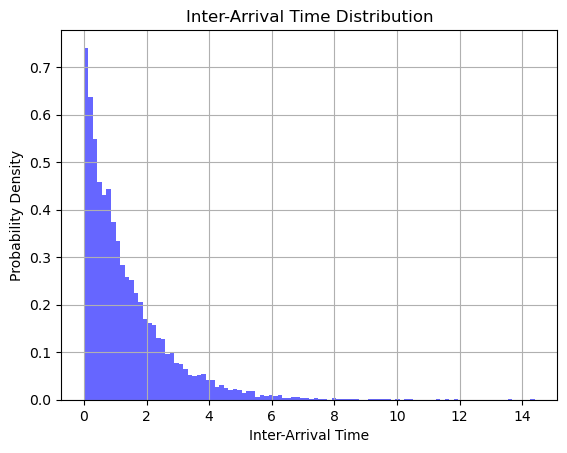

In [26]:
test_inter_arrival_times = genInitiationTime(inter_arrival_times.mean())

# Plot histogram of inter-arrival times
plt.hist(test_inter_arrival_times, bins=100, density=True, alpha=0.6, color='b')
plt.xlabel('Inter-Arrival Time')
plt.ylabel('Probability Density')
plt.title('Inter-Arrival Time Distribution')
plt.grid(True)
plt.show()

In [27]:
test_inter_arrival_times.mean()

1.3522134520978657

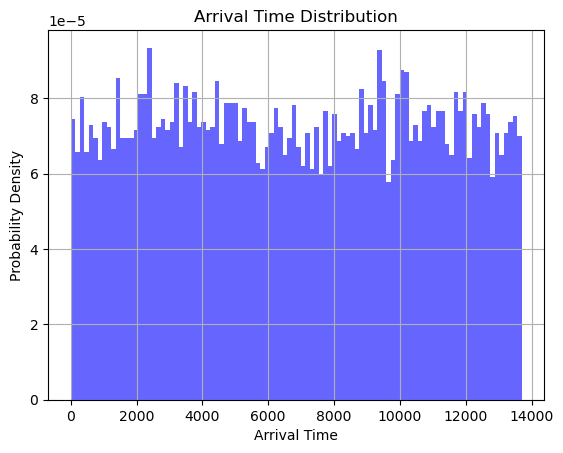

In [28]:
# Plot histogram of inter-arrival times
plt.hist(arrival_timings, bins=100, density=True, alpha=0.6, color='b')
plt.xlabel('Arrival Time')
plt.ylabel('Probability Density')
plt.title('Arrival Time Distribution')
plt.grid(True)
plt.show()

In [29]:
arrival_timings.mean()

6838.1879853029195

In [30]:
print(np.random.default_rng().exponential(1/(10000/inter_arrival_times.sum()), 10000).mean())
print(1/(10000/inter_arrival_times.sum()))
print(genInitiationTime(inter_arrival_times.mean()).mean())
inter_arrival_times.mean()

1.3786161213638406
1.3696799447838768
1.3537905832679336


1.3698169264765245

In [31]:
baseStations = df["Base station "].values

<Axes: xlabel='Base station ', ylabel='Frequency'>

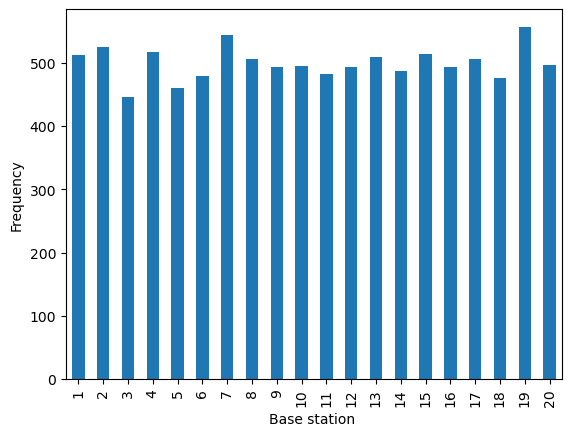

In [32]:
# Plot frequency bar graph for Base Stations Number
fig, ax = plt.subplots()
plt.ylabel("Frequency")
df["Base station "].value_counts().sort_index().plot(ax=ax, kind='bar')

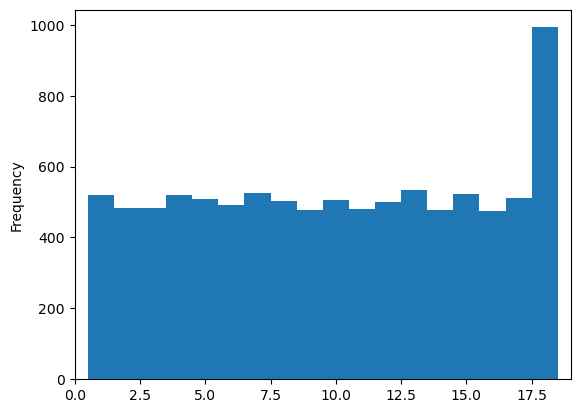

In [40]:
test_baseStations = genBaseStation()

# Plot frequency bar graph for Base Stations Number
fig, ax = plt.subplots()
plt.ylabel("Frequency")
hist, bin_edges = np.histogram(test_baseStations, bins = range(20))
plt.bar(bin_edges[:-1], hist, width = 1)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show()   

In [ ]:
callDurationsSec = df["Call duration (sec)"].to_numpy()

In [ ]:
callDurationsMS = callDurationsSec * 1000.0

NameError: name 'callDurationsSec' is not defined

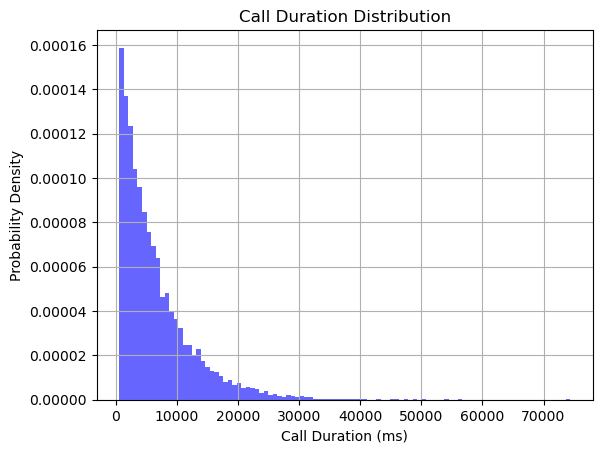

In [ ]:
# Plot histogram of inter-arrival times
plt.hist(callDurationsMS, bins=100, density=True, alpha=0.6, color='b')
plt.xlabel('Call Duration (ms)')
plt.ylabel('Probability Density')
plt.title('Call Duration Distribution')
plt.grid(True)
plt.show()

In [ ]:
print(callDurationsMS.mean())
print(1/(callDurationsMS.mean()))

6590.154044324862
0.0001517415212564195


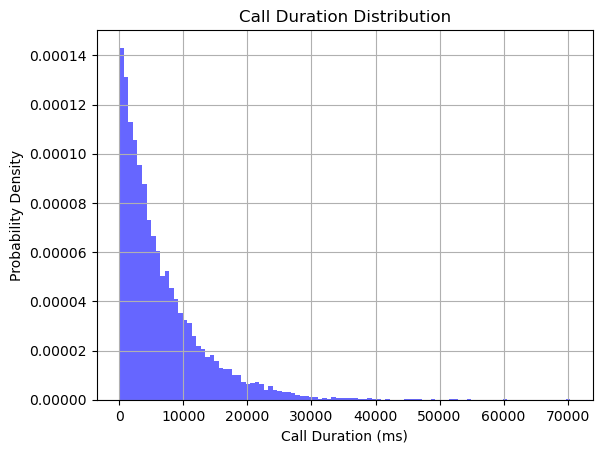

In [ ]:
test_callDurationsMS = genCallDuration(1/(10000/callDurationsMS.sum()))

# Plot histogram of inter-arrival times
plt.hist(test_callDurationsMS, bins=100, density=True, alpha=0.6, color='b')
plt.xlabel('Call Duration (ms)')
plt.ylabel('Probability Density')
plt.title('Call Duration Distribution')
plt.grid(True)
plt.show()

In [ ]:
print(1/(10000/callDurationsMS.sum()))
print(genInitiationTime(callDurationsMS.mean()).mean())
callDurationsMS.mean()

6590.154044324861
6589.545155371444


6590.154044324862

In [ ]:
velocities = df["velocity (km/h)"].to_numpy()

In [ ]:
velocitiesCMperMS = velocities / 1000.0 / 100.0 * 60.0 * 60.0

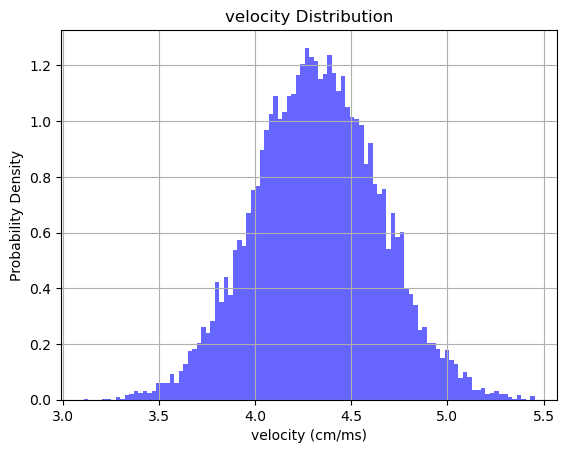

In [ ]:
# Plot histogram of inter-arrival times
plt.hist(velocitiesCMperMS, bins=100, density=True, alpha=0.6, color='b')
plt.xlabel('velocity (cm/ms)')
plt.ylabel('Probability Density')
plt.title('velocity Distribution')
plt.grid(True)
plt.show()

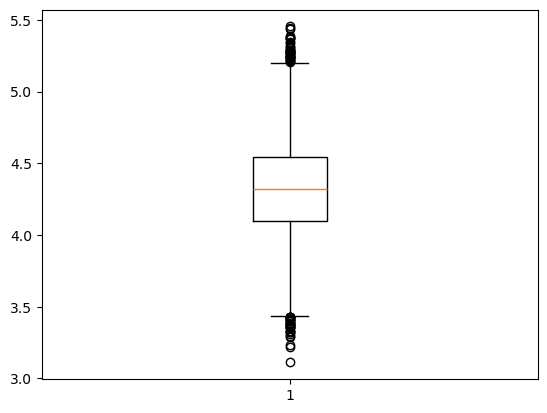

In [ ]:
plt.boxplot(velocitiesCMperMS)
plt.show()

In [ ]:
print(velocitiesCMperMS.mean())
print(velocitiesCMperMS.var())
print(velocitiesCMperMS.std())

4.322595528606874
0.1054105112485041
0.32466984961419515
